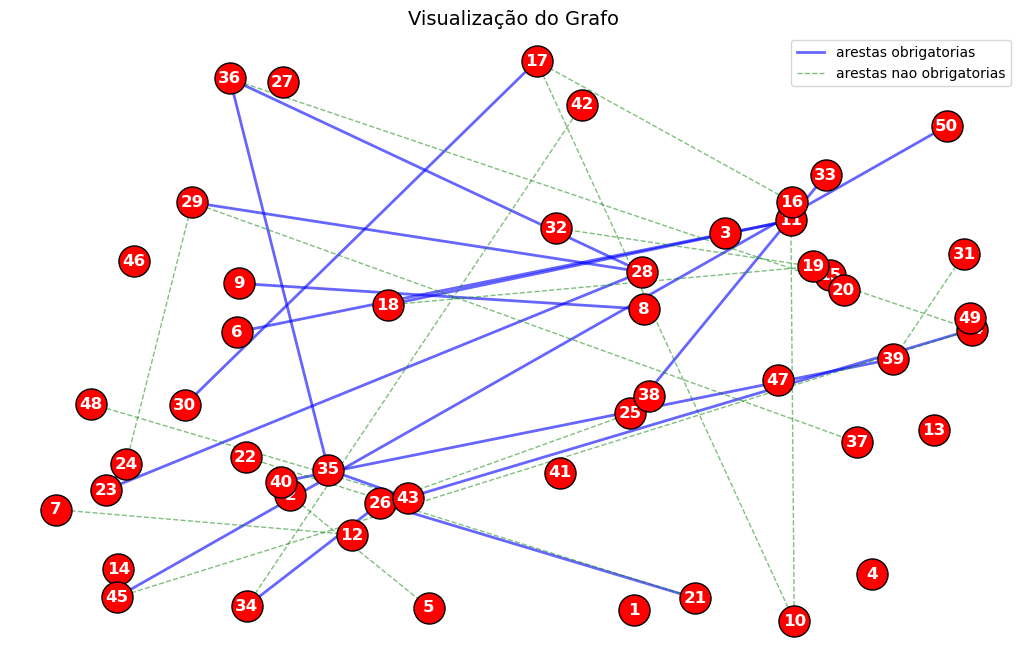

In [14]:
import matplotlib.pyplot as plt
import random
from analise_grafo import ler_arquivo_dados

# carregar os dados do grafo a partir do arquivo
caminho_arquivo = "dados/teste.dat"
dados_grafo, total_nos = ler_arquivo_dados(caminho_arquivo)

# gerar posicoes aleatorias para os nos
random.seed(42)  # definir semente para manter os mesmos valores
posicoes = {no: (random.uniform(0, 1), random.uniform(0, 1)) for no in range(1, total_nos + 1)}

# criar figura para exibir o grafo
fig, ax = plt.subplots(figsize=(13, 8))

# plotar arestas obrigatorias com linha azul continua
for aresta in dados_grafo["arestas_obrigatorias"]:
    de_no, para_no, *_ = aresta
    x1, y1 = posicoes[de_no]
    x2, y2 = posicoes[para_no]
    ax.plot([x1, x2], [y1, y2], 'b-', linewidth=2, alpha=0.6, label="arestas obrigatorias")

# plotar arestas nao obrigatorias com linha verde pontilhada
for aresta in dados_grafo["arestas_nao_obrigatorias"]:
    de_no, para_no, *_ = aresta
    x1, y1 = posicoes[de_no]
    x2, y2 = posicoes[para_no]
    ax.plot([x1, x2], [y1, y2], 'g--', linewidth=1, alpha=0.5, label="arestas nao obrigatorias")

# plotar nos do grafo em vermelho com borda preta
for no, (x, y) in posicoes.items():
    ax.scatter(x, y, color='red', s=500, edgecolors='black', zorder=3)
    ax.text(x, y, str(no), fontsize=12, ha='center', va='center', color='white', fontweight='bold')

# remover elementos duplicados da legenda
handles, labels = ax.get_legend_handles_labels()
legenda = dict(zip(labels, handles))
ax.legend(legenda.values(), legenda.keys(), loc="upper right")

# configurar o grafico
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Visualização do Grafo", fontsize=14)
ax.set_frame_on(False)

# exibir o grafico
plt.show()
